# Tutorial - AEDAT files annotation

This tutorial will cover all the basic steps needed to provide annotations to AEDAT files. The overall pipeline can be divided in three sections:

1. Creating a video from the aedat file.
2. Use CVAT to define and perform an annotation task on the video file.
3. Load the annotations together with the events file.

## 1. Creating video for annotation

The function `aedat_convert_to_video(file_path: str, **kwargs)` can be used to create an `mp4` video from an aedat file. It's necessary to pass the wanted `time_window` as a `kwargs` as follows:

```
>>> aedat_convert_to_video(aedat_file, time_window=10000)
```

Behind the scenes this function:

1. Loads the `aedat` file with the already existing function `aermanager.dataset_generator.dataset_content_generator`. The `**kwargs` will be forwarded to the `dataset_content_generator(...)` function.
2. Normalizes the frames between 0 and 255
3. Saves the frames in a video, the video has the same filename of the aedat file with `mp4` extension.

In [1]:
from aermanager.cvat.aedat_to_video import aedat_convert_to_video

aedat_folder = '/home/marco/repos/demos/cvat-demo/aedat'
aedat_file = aedat_folder + '/four_obj_static.aedat4'
video_file_name = aedat_folder + '/four_obj_static.mp4'

In [2]:
%%time
aedat_convert_to_video(aedat_file, time_window=10000)

CPU times: user 3.95 s, sys: 384 ms, total: 4.33 s
Wall time: 5.37 s


In [3]:
!ls $aedat_folder/*mp4

/home/marco/repos/demos/cvat-demo/aedat/four_obj_static.mp4


In [4]:
# !vlc $video_file_name &> /dev/null

## 2. Creating an annotation task on CVAT

This is better to be done within the CVAT WUI for the moment, even though there are tools to do this programmaticaly (see `cli.py` in the official repo: https://github.com/openvinotoolkit/cvat/tree/develop/utils/cli). Currently only one video file per annotation task is supported.

From a given annotation task two files must be downloaded:

1. The JSON file containing the labels definition.
2. CVAT annotations with the format "CVAT for a video 1.1" (XML)

## 3. Load the annotations together with the events file.

Events annotations can be loaded with the function `aermanager.annotate_aedat.aedat.load_annotated`. The function requires as arguments:

1. The `aedat` file path.
2. The XML file path with the annotations (in the "CVAT for video 1.1" format)
3. The JSON file with the labels used during the annotation.

The `**kwargs` of `load_annotated` will be forwarded to the `dataset_content_generator(...)` function: it's not necessary for the `time_window` to be the same used for the annotation video generation.

In [5]:
from aermanager.annotate_aedat import aedat_load_annotated
import ipywidgets as widgets
import numpy as np

In [6]:
aedat_file = '/home/marco/repos/demos/cvat-demo/aedat/four_obj_static.aedat4'
annotations_file = '/home/marco/repos/aermanager/test/dummy_video_annotations.xml'
labels_file = '/home/marco/repos/aermanager/test/dummy_labels.json'

The `aedat_load_annotated` function will return:

- `sliced_xytp`, returns the events sliced based on the selected hyperparameter
- `frames`, 2D frames of accumulated events.
- `annotations`, list with the same structure of `sliced_xytp`, provides event-wise annotation.

The labels values are automatically generated when loading the `dummy_labels.json` file. Currently labels are an 8-bit integer associated to an event: this implies the limitation of supporting only one label per event at the moment.

**Please note how in the next cell we're using a different hyperparameter (`spike_count=5000`) to slice the events into frames than the one used during video generation (which was `time_window=10000`).**

In [7]:
%%time
sliced_xytp, frames, annotations = aedat_load_annotated(aedat_file, annotations_file, labels_file, spike_count=5000)

CPU times: user 4.3 s, sys: 855 ms, total: 5.15 s
Wall time: 3.83 s


In [8]:
# Sanity check of events annotations dimensions

assert len(annotations) == len(sliced_xytp), "Annotations and events size must match!"

num_slices = len(annotations)

for i in range(0, num_slices):
    assert len(annotations[i]) == len(sliced_xytp[i]), "Slices of events and of annotation must have the same size!"

## 4. Visualization of annotations

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors

<IPython.core.display.Javascript object>


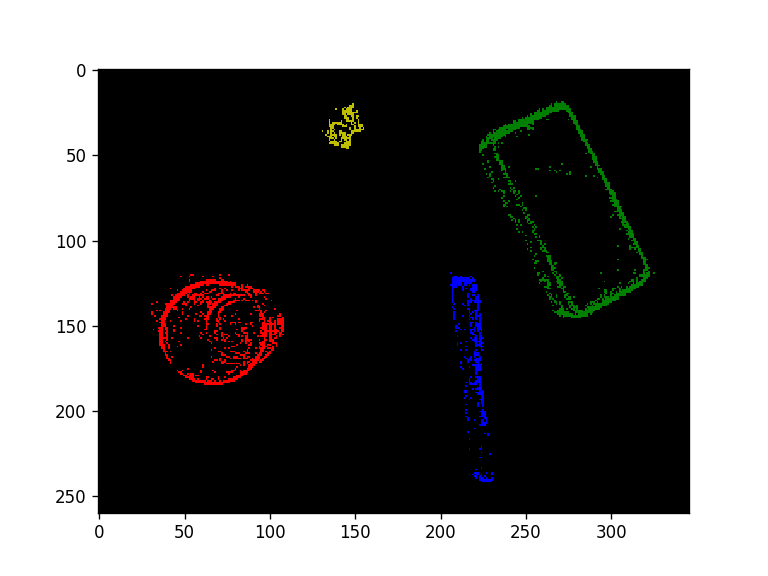

interactive(children=(IntSlider(value=31, description='x', max=63), Output()), _dom_classes=('widget-interact'…

In [10]:
x_max = frames.shape[-1]
y_max = frames.shape[-2]

image = np.zeros((y_max, x_max), dtype='uint8')

fig = plt.figure()
p = fig.add_subplot(1, 1, 1)

cmap = colors.ListedColormap(['k','b','y','g','r'])

im_plot = p.imshow(image, interpolation='nearest', vmin=0, vmax=4, cmap=cmap)

def update(x):
    image = np.zeros((y_max, x_max), dtype='uint8')
    image[sliced_xytp[x]['y'], sliced_xytp[x]['x']] = annotations[x]
    im_plot.set_data(image)
    
    fig.canvas.draw()
    
widgets.interact(update, x=(0, 63)); # The range of frames was empirically set.

In order to create an animation adapt the following snippet:

```
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation, rc

x_max = frames.shape[-1]
y_max = frames.shape[-2]

image = np.zeros((y_max, x_max), dtype='uint8')

fig = plt.figure()
p = fig.add_subplot(1, 1, 1)

cmap = colors.ListedColormap(['k','b','y','g','r'])

im_plot = p.imshow(image, interpolation='nearest', vmin=0, vmax=4, cmap=cmap)

def animate(x):
    image.fill(0)
    image[sliced_xytp[x]['y'], sliced_xytp[x]['x']] = annotations[x]
    im_plot.set_data(image)
    return (im_plot,)
    
anim = animation.FuncAnimation(fig, animate, frames=np.arange(0, 153), interval=1, blit=True)

anim.save('myAnimation.gif', writer='imagemagick', fps=30);
```